In [204]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [205]:
# initializing parameters
n = 3.4
n_out = 1.0
L1 = 10e-6 # 10e-6m
L2 = 15e-6 # 15e-6m
c = 3e8

<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
<>:38: SyntaxWarning: invalid escape sequence '\s'
<>:39: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2036146800.py:38: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(kx_line, ky_line_upper, 'k--', label=f'Upper Boundary: $k_y = k_x \sqrt{{n^2-1}}$')
/tmp/ipython-input-2036146800.py:39: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(kx_line, ky_line_lower, 'k--', label=f'Lower Boundary: $k_y = k_x / \sqrt{{n^2-1}}$')


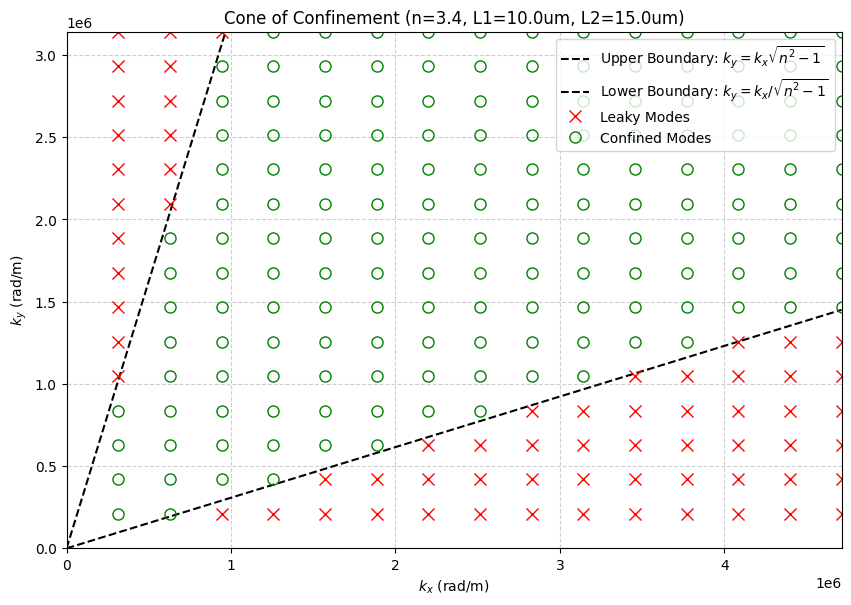

In [206]:
n_sq_minus_1 = n**2 - 1

p_max = 15
q_max = 15
kx_max_vis = p_max * np.pi / L1
ky_max_vis = q_max * np.pi / L2
kx_line = np.linspace(0, kx_max_vis, 100)

# Boundary 1: k_y^2 = (n^2 - 1) * k_x^2
ky_line_upper = kx_line * np.sqrt(n_sq_minus_1)

# Boundary 2: k_x^2 = (n^2 - 1) * k_y^2  =>  k_y = k_x / sqrt(n^2 - 1)
ky_line_lower = kx_line / np.sqrt(n_sq_minus_1)

# Generate the discrete grid
p_vals = np.arange(1, p_max + 1)
q_vals = np.arange(1, q_max + 1)
p_grid, q_grid = np.meshgrid(p_vals, q_vals)

kx_grid = p_grid * np.pi / L1
ky_grid = q_grid * np.pi / L2

# Classifying modes

# Condition 1 for confinement: (n^2 - 1) * k_y^2 > k_x^2
is_above_lower = (n_sq_minus_1 * ky_grid**2) > (kx_grid**2)

# Condition 2 for confinement: (n^2 - 1) * k_x^2 > k_y^2
is_below_upper = (n_sq_minus_1 * kx_grid**2) > (ky_grid**2)

# A mode is confined ONLY if it satisfies BOTH conditions
confined_mask = is_above_lower & is_below_upper
leaky_mask = ~confined_mask


plt.figure(figsize=(10, 10))
# Plot the boundary lines
plt.plot(kx_line, ky_line_upper, 'k--', label=f'Upper Boundary: $k_y = k_x \sqrt{{n^2-1}}$')
plt.plot(kx_line, ky_line_lower, 'k--', label=f'Lower Boundary: $k_y = k_x / \sqrt{{n^2-1}}$')

# Plot the leaky modes (red 'x')
plt.plot(kx_grid[leaky_mask], ky_grid[leaky_mask], 'rx',
         markersize=8, label='Leaky Modes')

# Plot the confined modes (green 'o')
plt.plot(kx_grid[confined_mask], ky_grid[confined_mask], 'go',
         markersize=8, mfc='none', label='Confined Modes')

plt.title(f'Cone of Confinement (n={n}, L1={L1*1e6}um, L2={L2*1e6}um)')
plt.xlabel('$k_x$ (rad/m)')
plt.ylabel('$k_y$ (rad/m)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Set equal aspect ratio (crucial for geometric plots)
plt.gca().set_aspect('equal', adjustable='box')

# Set plot limits
plt.xlim(0, kx_max_vis)
plt.ylim(0, ky_max_vis)
plt.show()

In [207]:
def calculate_freq(p, q, n, L1, L2, c):
    freq_squared = (c**2/(4*n**2)) * ((p/L1)**2 + (q/L2)**2)
    freq_Thz = np.sqrt(freq_squared)
    return freq_Thz / 1e12 # Convert to THz

#  Generate a large list of modes
p_max = 20
q_max = 20
modes = [] # List to store (frequency, p, q)
for p in range(1, p_max + 1):
    for q in range(1, q_max + 1):
        freq = calculate_freq(p, q, n, L1, L2, c)
        modes.append({'freq_thz': freq, 'p': p, 'q': q})


# Create a DataFrame for easy sorting and duplicate removal
df = pd.DataFrame(modes)
df = df.sort_values(by='freq_thz')

# # Add a rounded frequency column to handle floating point issues
df['freq_rounded'] = df['freq_thz'].round(4)

# Find first 10 distinct resonance frequencies
distinct_freqs = df.drop_duplicates(subset='freq_rounded')

print("--- First 10 Distinct Resonance Frequencies ---")
first_10_modes = distinct_freqs.head(10)
# Print the result formatted as a table
print(first_10_modes[['freq_thz', 'p', 'q']].to_string(index=False))

# Identify the lowest degenerate frequency
duplicates = df[df.duplicated(subset='freq_rounded', keep=False)]

if not duplicates.empty:
# Find the lowest frequency among all duplicates
  lowest_degenerate_freq = duplicates.iloc[0]['freq_rounded']
  print(f"\nLowest degenerate frequency found: {lowest_degenerate_freq:.4f} THz")

# Print all modes matching that degenerate frequency
  print("Corresponding degenerate (p, q) modes:")
  degenerate_modes = duplicates[duplicates['freq_rounded'] == lowest_degenerate_freq]
  print(degenerate_modes[['freq_thz', 'p', 'q']].to_string(index=False))
else:
  print("\nNo degenerate modes found.")

--- First 10 Distinct Resonance Frequencies ---
 freq_thz  p  q
 5.302281  1  1
 7.352941  1  2
 9.300817  2  1
 9.865006  1  3
10.604563  2  2
12.478355  2  3
12.564711  1  4
13.558154  3  1
14.483614  3  2
14.705882  2  4

Lowest degenerate frequency found: 19.7300 THz
Corresponding degenerate (p, q) modes:
 freq_thz  p  q
19.730012  4  3
19.730012  2  6


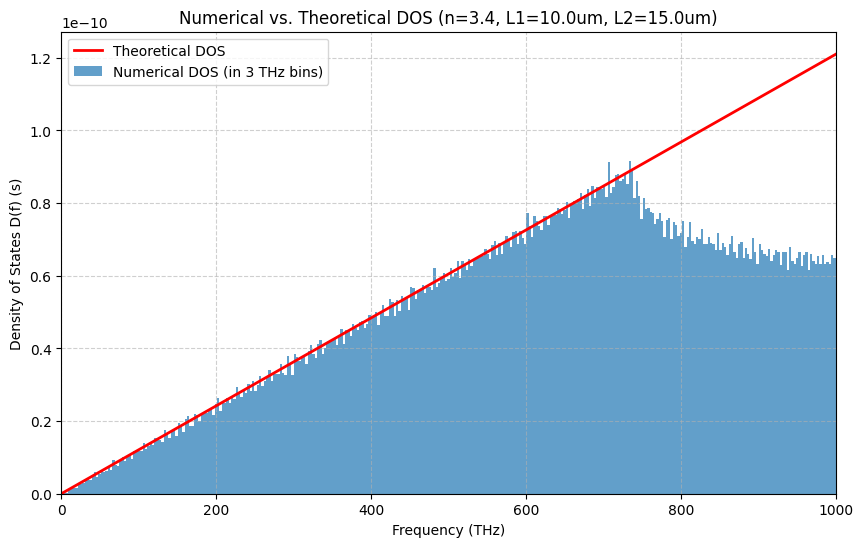

In [209]:
Area = L1 * L2
delta_f_thz = 3
delta_f_hz = delta_f_thz * 1e12 # 3 THz in Hz

def calculate_freq_thz(p, q, n, L1, L2, c):
    freq_squared = (c**2 / (4 * n**2)) * ( (p/L1)**2 + (q/L2)**2 )
    freq_hz = np.sqrt(freq_squared)
    return freq_hz / 1e12 # Convert to THz


p_max = 250 # Use 250 to get good data at high frequencies
q_max = 250
modes = []
for p in range(1, p_max + 1):
    for q in range(1, q_max + 1):
        freq = calculate_freq_thz(p, q, n, L1, L2, c)
        modes.append({'freq_thz': freq, 'p': p, 'q': q})

# Create a DataFrame to hold all frequencies
df = pd.DataFrame(modes)
all_freqs_thz = df['freq_thz'].values

max_freq_thz = 1000  # Set a plot limit
bins = np.arange(0, max_freq_thz + delta_f_thz, delta_f_thz)

# --- Numerical DOS (Histogram) ---
counts, bin_edges = np.histogram(all_freqs_thz, bins=bins)


numerical_dos = counts / delta_f_hz
# Get the center of each bin for plotting
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2


# Convert bin_centers from THz to Hz for the formula
f_hz_line = bin_centers * 1e12
theoretical_dos = (2 * np.pi * Area * n**2 * f_hz_line) / c**2


plt.figure(figsize=(10, 6))
# Plot the numerical DOS bars
plt.bar(bin_centers, numerical_dos, width=delta_f_thz, align='center',
        alpha=0.7, label=f'Numerical DOS (in {delta_f_thz} THz bins)')

plt.plot(bin_centers, theoretical_dos, 'r-', linewidth=2,
         label='Theoretical DOS')

plt.title(f'Numerical vs. Theoretical DOS (n={n}, L1={L1*1e6}um, L2={L2*1e6}um)')
plt.xlabel('Frequency (THz)')
plt.ylabel('Density of States D(f) (s)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xlim(0, max_freq_thz)
plt.ylim(0)
plt.show()

In [210]:
# Step 1: Calculate Critical Angle
theta_c_rad = np.arcsin(n_out / n)
theta_c_deg = np.degrees(theta_c_rad)
print(f"Critical Angle (GaAs to Air): {theta_c_deg:.3f} degrees")

tir_confined_modes = 0
print("\nChecking first 10 distinct modes:")
print("f (THz) | (p, q)   | k_x > k_air? (TIR on y-walls) | k_y > k_air? (TIR on x-walls) | Confined?")
print("-" * 75)

# Step 2 & 3: Loop, Calculate k-vectors, and Check Conditions
for index, mode in first_10_modes.iterrows():
    f_hz = mode['freq_thz'] * 1e12
    p = mode['p']
    q = mode['q']

    # Calculate the mode's k-vectors
    k_x = p * np.pi / L1
    k_y = q * np.pi / L2

    # Calculate the equivalent k-vector in air
    k_air = (2 * np.pi * f_hz) / c # This is omega / c

    # Check TIR Conditions: k_parallel > k_air
    # For y-walls (at x=0, L1), the parallel k-vector is k_y
    tir_at_x_walls = k_y > k_air

    # For x-walls (at y=0, L2), the parallel k-vector is k_x
    tir_at_y_walls = k_x > k_air

    is_confined = tir_at_x_walls and tir_at_y_walls
    if is_confined:
        tir_confined_modes += 1

    print(f" {mode['freq_thz']:<6.2f} | ({p:<2.0f}, {q:<2.0f}) | {str(tir_at_y_walls):<27} | {str(tir_at_x_walls):<27} | {is_confined}")

print(f"\nTotal confined modes (out of first 10): {tir_confined_modes}")

Critical Angle (GaAs to Air): 17.105 degrees

Checking first 10 distinct modes:
f (THz) | (p, q)   | k_x > k_air? (TIR on y-walls) | k_y > k_air? (TIR on x-walls) | Confined?
---------------------------------------------------------------------------
 5.30   | (1 , 1 ) | True                        | True                        | True
 7.35   | (1 , 2 ) | True                        | True                        | True
 9.30   | (2 , 1 ) | True                        | True                        | True
 9.87   | (1 , 3 ) | True                        | True                        | True
 10.60  | (2 , 2 ) | True                        | True                        | True
 12.48  | (2 , 3 ) | True                        | True                        | True
 12.56  | (1 , 4 ) | True                        | True                        | True
 13.56  | (3 , 1 ) | True                        | False                       | False
 14.48  | (3 , 2 ) | True                        | True     

In [213]:
f_hz = mode['freq_thz'] * 1e12
k_air = (2 * np.pi * f_hz) / c # This is omega / c

In [216]:
print(k_air)
k_y = 1 * np.pi / L2

307999.2797637052


In [217]:
print(k_y == k_air)

False


In [218]:
print(k_y)

209439.51023931953


In [219]:
kx = 1*np.pi/ L1